# Проект с решением задачи классификации музыкальных жанров

In [ ]:
# Данные GTZAN Dataset - Music Genre Classification для обучения можно скачать по ссылке:
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
# Примечание: В исходном Dataset в одном из классов есть битый *.wav-файл, для корректной работы его необходимо удалить

In [1]:
# импорт необходимых зависимостей
import json
import os
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
# Объявление глобальных переменных

DATASET_PATH = "D:\\GTZAN Dataset\\Data\\genres_original" # Пропиываем ваш путь
JSON_PATH = "D:\\GTZAN Dataset\\data.json" # Прописываем ваш путь
SAMPLE_RATE = 22050 # указываем частоту дискретизации
TRACK_DURATION = 30 # 30 секунд в каждом треке
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION # вычисляем количесвто отсчётов в треке

## Извлечение признакового пространства из аудиофайлов

In [3]:
# функция, извлекающая признаки аудиосигналов, используем MFCCs
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    
    # словарь с картой, метки классов и MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    
    num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    # прохождение по директориям с файлами
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            # Сохранение меток классов 
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # обработка всех файлов в директориях с классами
            for f in filenames:

                # считывание аудио данных
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # обрботка всех сегментов аудиофайлов
                for d in range(num_segments):

                    # вычисляем начало и конец для конкретного сегмента
                    start = num_samples_per_segment * d
                    finish = start + num_samples_per_segment

                    # извлечение mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, 
                        n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # сохраняем признаки для каждого вектора
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        #print("{}, segment:{}".format(file_path, d+1)) - можно включить для отображения логов

    # сохраняем в json
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


In [4]:
# При запуске функции программа упадёт, так как будет ругаться на битый файл. 
# Путь к этому файлу будет указан в описании к ошибке. Просто удалите этот файл и запустите функцию заново    

save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: D:\GTZAN Dataset\Data\genres_original\blues

Processing: D:\GTZAN Dataset\Data\genres_original\classical

Processing: D:\GTZAN Dataset\Data\genres_original\country

Processing: D:\GTZAN Dataset\Data\genres_original\disco

Processing: D:\GTZAN Dataset\Data\genres_original\hiphop

Processing: D:\GTZAN Dataset\Data\genres_original\jazz

Processing: D:\GTZAN Dataset\Data\genres_original\metal

Processing: D:\GTZAN Dataset\Data\genres_original\pop

Processing: D:\GTZAN Dataset\Data\genres_original\reggae

Processing: D:\GTZAN Dataset\Data\genres_original\rock


## Построение архитектуры полносвязной нейросети для обучения

In [8]:
# Загрузка данных из файла

DATA_PATH = "D:\\GTZAN Dataset\\data.json" # указывайте ваш путь к файлу

def load_data(data_path):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Данные успешно загружены!")

    return  X, y

## Описание архитектуры

In [19]:
# загрузка признаков и меток
X, y = load_data(DATA_PATH)

# разбиение выборки на train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# топология сети
model = keras.Sequential([

    # входной слой
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1-ый слой
    keras.layers.Dense(512, activation='relu'),
        
    # 2-ой слой
    keras.layers.Dense(256, activation='relu'),
        
    # 3-й слой
    keras.layers.Dense(64, activation='relu'),

    # выходной слой
    keras.layers.Dense(10, activation='softmax')
])

# компиляция модели
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Данные успешно загружены!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1690)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               865792    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [20]:
# обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
250/250 [==============================] - 3s 11ms/step - loss: 5.2471 - accuracy: 0.2243 - val_loss: 2.1482 - val_accuracy: 0.2508
Epoch 2/50
250/250 [==============================] - 2s 8ms/step - loss: 1.9121 - accuracy: 0.3287 - val_loss: 2.0409 - val_accuracy: 0.2893
Epoch 3/50
250/250 [==============================] - 2s 9ms/step - loss: 1.7618 - accuracy: 0.3669 - val_loss: 1.9118 - val_accuracy: 0.3393
Epoch 4/50
250/250 [==============================] - 2s 9ms/step - loss: 1.6493 - accuracy: 0.4011 - val_loss: 1.8224 - val_accuracy: 0.3829
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 1.5734 - accuracy: 0.4303 - val_loss: 1.8527 - val_accuracy: 0.3734
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 1.5086 - accuracy: 0.4551 - val_loss: 1.8938 - val_accuracy: 0.3959
Epoch 7/50
250/250 [==============================] - 2s 7ms/step - loss: 1.4320 - accuracy: 0.4840 - val_loss: 1.7915 - val_accuracy: 0.4299
Epoch

## Визуализация результатов обучения

In [21]:
def plot_history(history):
    fig, axs = plt.subplots(2)
    # создание accuracy subplot
    axs[0].plot(history.history["accuracy"], label='train accuracy')
    axs[0].plot(history.history["val_accuracy"], label='test accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')
    axs[0].set_title('Accuracy eval')
    fig.set_figwidth(10)
    fig.set_figheight(10)
    # создание error subplot
    axs[1].plot(history.history["loss"], label='train error')
    axs[1].plot(history.history["val_loss"], label='test error')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Error')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Error eval')
    
    plt.show()

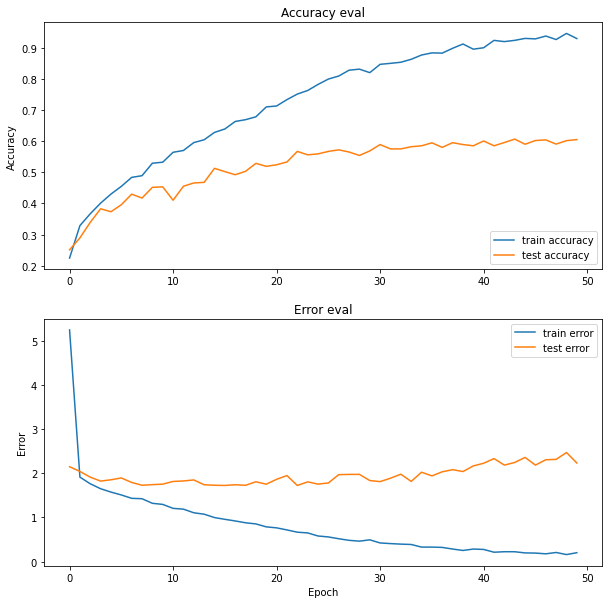

In [22]:
plot_history(history) # визуализация результата

### В результате анализа графиков наблюдаем процесс переобучения сети. Это видно из разницы accuracy на обучающей и валидационной выборке. Существует несколько эффективных способов борьбы с overfitting: упрощение архитектуры сети, аугментация данных, ранняя остановка обучения, удаление выбросов и регуляризация.

## Dropout & Regularization

In [23]:
# топология сети
model_2 = keras.Sequential([

    # входной слой
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1-ый слой
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 2-ой слой
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # 3-й слой
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    
    # выходной слой
    keras.layers.Dense(10, activation='softmax')
])

# компиляция модели
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1690)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               865792    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [24]:
# обучение модели
history_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
250/250 [==============================] - 5s 15ms/step - loss: 18.0964 - accuracy: 0.1526 - val_loss: 3.4287 - val_accuracy: 0.1662
Epoch 2/100
250/250 [==============================] - 3s 13ms/step - loss: 5.3837 - accuracy: 0.1378 - val_loss: 3.4691 - val_accuracy: 0.1421
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 4.0744 - accuracy: 0.1242 - val_loss: 3.4813 - val_accuracy: 0.1351
Epoch 4/100
250/250 [==============================] - 3s 11ms/step - loss: 3.7396 - accuracy: 0.1267 - val_loss: 3.4540 - val_accuracy: 0.1522
Epoch 5/100
250/250 [==============================] - 3s 11ms/step - loss: 3.6216 - accuracy: 0.1304 - val_loss: 3.4223 - val_accuracy: 0.1752
Epoch 6/100
250/250 [==============================] - 3s 11ms/step - loss: 3.5479 - accuracy: 0.1453 - val_loss: 3.3905 - val_accuracy: 0.1882
Epoch 7/100
250/250 [==============================] - 3s 11ms/step - loss: 3.5189 - accuracy: 0.1488 - val_loss: 3.3829 - val_accuracy

## Визуализация результатов для улучшенной модели полносвязной сети

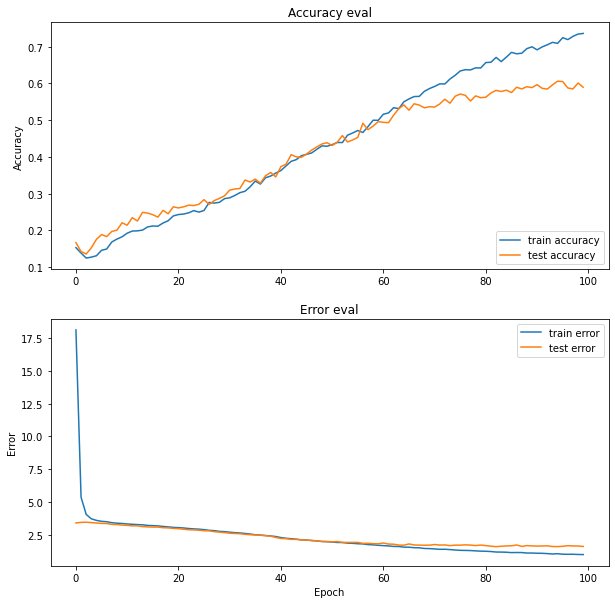

In [25]:
plot_history(history_2) 

### Из графиков видно, что для улучшения модели можно использовать раннюю остановку обучения на эпохе №70. Достижимая точность данной модели 73%.

# Построение архитектуры свёрточной нейросети для обучения

In [5]:
# функция загрузки и разбиения данных на train/validation/test

def prepare_datasets(test_size, val_size):
    # загрузка данных
    X, y = load_data(DATA_PATH)
    
    # разбиание данных на train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    # создание выборки train/val 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size)
    
    # 3D-массив (изображение с MFCCs) размером (130, 13, 1)
    X_train = X_train[..., np.newaxis] # 4d массив = (num_samples, 130, 13, 1)
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
# функция построения модели
def build_model(input_shape):
    
    #create model
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    #output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [9]:
# создание train, validation и test наборов данных
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(0.25, 0.2)

Данные успешно загружены!


In [10]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(5991, 130, 13, 1) (1498, 130, 13, 1) (2497, 130, 13, 1) (5991,) (1498,) (2497,)


In [11]:
# построение CNN
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model_3 = build_model(input_shape)

In [12]:
# компиляция сети
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_3.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics="accuracy")

In [13]:
# обучение CNN
history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=30)

Epoch 1/30
188/188 [==============================] - 8s 35ms/step - loss: 2.3674 - accuracy: 0.2344 - val_loss: 1.8912 - val_accuracy: 0.3451
Epoch 2/30
188/188 [==============================] - 5s 28ms/step - loss: 1.8618 - accuracy: 0.3684 - val_loss: 1.5509 - val_accuracy: 0.4486
Epoch 3/30
188/188 [==============================] - 5s 25ms/step - loss: 1.6300 - accuracy: 0.4355 - val_loss: 1.3844 - val_accuracy: 0.5160
Epoch 4/30
188/188 [==============================] - 5s 25ms/step - loss: 1.4825 - accuracy: 0.4831 - val_loss: 1.2935 - val_accuracy: 0.5294
Epoch 5/30
188/188 [==============================] - 5s 25ms/step - loss: 1.3711 - accuracy: 0.5143 - val_loss: 1.2102 - val_accuracy: 0.5734
Epoch 6/30
188/188 [==============================] - 5s 25ms/step - loss: 1.3102 - accuracy: 0.5443 - val_loss: 1.1579 - val_accuracy: 0.5814
Epoch 7/30
188/188 [==============================] - 5s 26ms/step - loss: 1.2517 - accuracy: 0.5547 - val_loss: 1.1168 - val_accuracy: 0.6015

In [26]:
# оценка работы CNN на тесте
test_error, test_accuracy = model_3.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))

63/63 [==============================] - 1s 11ms/step - loss: 0.5686 - accuracy: 0.8143
Accuracy on test set is: 0.8143143057823181


## Предсказание данных

In [15]:
# предсказание на данных
X = X_test[0][np.newaxis, ...]
y = y_test[0]   

prediction = model_3.predict(X)
predicted_index = np.argmax(prediction, axis=1)
print("Expected index: {}, Predicted index: {}".format(y, predicted_index))

Expected index: 6, Predicted index: [6]


## Визуализация результата обучения CNN

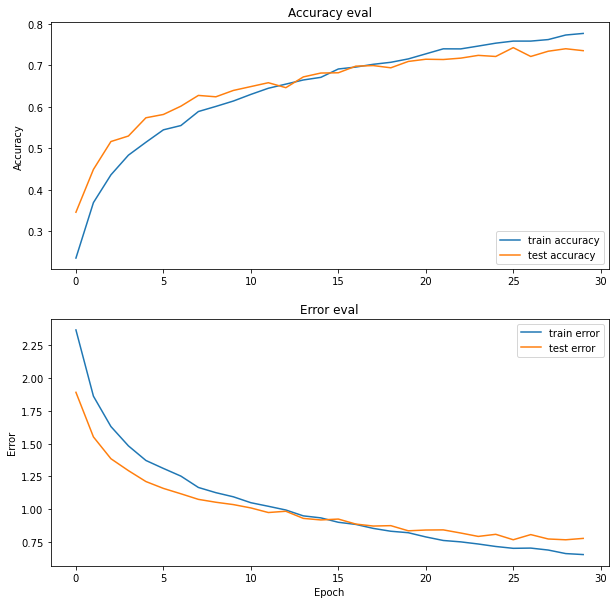

In [18]:
plot_history(history_3) # визуализация результата

### Обучение свёрточной нейросети на тесте даёт среднюю accuracy 72%. Переобучения и неодообучения не наблюдается.